In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = [load_array[0][20], load_array[0][50]]
inh = [load_array[1][20], load_array[1][50]]

folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = str(folder[1])

file_ = 'up.pickle'

c_var = [0,1]
if len(folder) == 4:
    if folder[3] == 'e':
        p_var = [0]
    elif folder[3] == 'i':
        p_var = [1]
else:
    p_var = [0,1]
    
print(p_var)

step1 = 1
step2 = 10
step3 = 100

/2_e
[0]


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
d_array = np.arange(20., 300, 0.1)
t0_array = d_array - 20.
t_pen = np.zeros(( t0_array.shape ))
for i in range(len(t_pen)):
    t_pen[i] = t0_array[i] / d_array[i] 

In [5]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-12
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
    cost_index = 2
else:
    factor_ws = 0.
    factor_we = 1.
    cost_index = 1
    
maxC = [1000., -1000., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [6]:
bestControl_ = np.array( [[None] * len(t_pen)] * len(exc) )
bestState_ = np.array( [[None] * len(t_pen)] * len(exc) )
cost_ = np.array( [[None] * len(t_pen)] * len(exc) )
costnode_ = np.array( [[None] * len(t_pen)] * len(exc) )
weights_ = np.array( [[None] * len(t_pen)] * len(exc) )
convergence_ = np.array( [[None] * len(t_pen)] * len(exc) )

initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

print(bestControl_.shape)

(2, 2800)


In [19]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]
    bestState_ = load_array[1]
    cost_ = load_array[2]
    costnode_ = load_array[3]
    weights_ = load_array[4]

file found


In [8]:
# get initial parameters and target states
# -------  20 0.4500000000000001 0.4750000000000002
#-------  50 0.47500000000000014 0.6000000000000003

i_range = range(len(exc))
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

-------  0 0.4500000000000001 0.4750000000000002
-------  1 0.47500000000000014 0.6000000000000003


In [31]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    dur = d_array[0]
    aln.params.duration = dur
    
    target_ = aln.getZeroTarget()
    target_[:,0,:] = target[i][0]
    target_[:,1,:] = target[i][1]
            
    cost.setParams(1.0, 0.0, 0.0)

    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, phi1_, costnode_init_ = aln.A1(
        control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
        prec_variables_ = p_var, transition_time_ = t_pen[0])
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4500000000000001 0.4750000000000002
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  12801.807032522984
RUN  0 , total integrated cost =  12801.807032522984
Gradient descend method:  None
RUN  0 , total integrated cost =  12801.807032522984
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  1 0.47500000000000014 0.6000000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
initial cost =  16022.670213255857
RUN  0 , total integrated cost =  16022.670213255857
Gradient descend method:  None
RUN  0 , total integrated cost =  16022.670213255857
Improved over  0  iterations in  0.0  seconds by  0.0  percent.


In [30]:
bestControl_[1][0] = None
convergence_[1][0] = None

In [36]:
tol = 1e-8

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    cgv = None
    j = 0
    max_it = 1000

    while not convergence_[i][j]:

        dur = d_array[0]
        aln.params.duration = dur
        cost.setParams(1.0, factor_we, factor_ws)
        weights_[i][j] = [1.0, factor_we, factor_ws]
        
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_[i][j]) == type(None) or np.amax(np.abs(bestControl_[i][j])) < 1e-6:
            control0 = aln.getZeroControl()
            control0[0,0,10:-10] = 1.
        else:
            control0 = bestControl_[i][j][:,:,n_pre-1:-n_post+1]

        bestControl_[i][j], bestState_[i][j], cost_[i][j], runtime_, grad_, phi_, phi1_, costnode_[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if max_it > 1:
            if cost_[i][j][2] == 0.:
                convergence_[i][j] = True
                continue

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][cost_index][0][:2])

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  0 0.4500000000000001 0.4750000000000002
-------  1 0.47500000000000014 0.6000000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  976.9476799313891
RUN  0 , total integrated cost =  976.9476799313891
Gradient descend method:  None
RUN  1 , total integrated cost =  976.9476799210269
RUN  2 , total integrated cost =  976.947679910659
RUN  3 , total integrated cost =  976.9476799001941
RUN  4 , total integrated cost =  976.9476798896858
RUN  5 , total integrated cost =  976.9476798790727
RUN  6 , total integrated cost =  976.9476798687399
RUN  7 , total integrated cost =  976.9476798583939
RUN  8 , total integrated cost =  976.947679847889
RUN  9 , total integrated cost =  976.9476798374012
RUN  10 , total integrated cost =  976.9476798271039
RUN  11 , total integrated cost =  976.9476798168723
RUN  12 , total integrated cost =  976.9476798063749
RUN  13 , total integrated cost =  976.9476797960085
RUN  14 , total integrated cost =  976

RUN  700 , total integrated cost =  976.947673538031
RUN  800 , total integrated cost =  976.94767352335
RUN  900 , total integrated cost =  976.9476735218659
RUN  1000 , total integrated cost =  976.947673520739
RUN  1000 , total integrated cost =  976.947673520739
Improved over  1000  iterations in  63.79653034103103  seconds by  1.2705953622571542e-08  percent.
cost splitting :  [569.98702493   0.        ] [4.06835683e+02 1.24965613e-01]
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
initial cost =  976.947673520739
RUN  0 , total integrated cost =  976.947673520739
Gradient descend method:  None
RUN  1 , total integrated cost =  976.947673520727
RUN  2 , total integrated cost =  976.9476735207171
RUN  3 , total integrated cost =  976.9476735207065
RUN  4 , total integrated cost =  976.9476735206969
RUN  5 , total integrated cost =  976.9476735206867
RUN  6 , total integrated cost =  976.9476735206769
RUN  7 , total integrated cost =  976.947673520667
RUN  8 , t

In [23]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 0
    step = step1
    
    if i == 0:
        continue

    while j < 2001:
        
        if convergence_[i][j]:
            j += step
            continue

        print('-----', j)

        dur = round(d_array[j],1)
        aln.params.duration = dur
        max_it = int(1000)  

        setinit(initVars[i], aln)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_[i][j]) == type(None):
            control0 = aln.getZeroControl()
            control0[:,:,:-step] = bestControl_[i][j-step][:,:,n_pre-1:-n_post+1]

        else:
            control0 = bestControl_[i][j][:,:,n_pre-1:-n_post+1]
            
        weights_[i][j] = cost.getParams()

        bestControl_[i][j], bestState_[i][j], cost_[i][j], runtime_, grad_, phi_, phi1_, costnode_[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_[i][j][-1] == 0.:
            convergence_[i][j] = True
            if j >= 10:
                step = step2
            if j >=1000:
                step = step3

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][cost_index][0][:2])

        with open(file_,'wb') as f:
            pickle.dump([bestControl_, bestState_, cost_, costnode_, weights_], f)

-------  0 0.4500000000000001 0.4750000000000002
-------  1 0.47500000000000014 0.6000000000000003
----- 1
interpolate adjoint :  True True True
initial cost =  819.5606871120505
RUN  0 , total integrated cost =  819.5606871120505
Gradient descend method:  None
RUN  1 , total integrated cost =  819.5606197895069
RUN  2 , total integrated cost =  819.5605771965135
RUN  3 , total integrated cost =  819.560560863232
RUN  4 , total integrated cost =  819.5605466788886
RUN  5 , total integrated cost =  819.5605323030592
RUN  6 , total integrated cost =  819.5605185559177
RUN  7 , total integrated cost =  819.5605056201815
RUN  8 , total integrated cost =  819.5604928137711
RUN  9 , total integrated cost =  819.5604802515904
RUN  10 , total integrated cost =  819.5604682465391
RUN  11 , total integrated cost =  819.5604559040494
RUN  12 , total integrated cost =  819.5604439435733
RUN  13 , total integrated cost =  819.5604325213968
RUN  14 , total integrated cost =  819.5604212543312
RUN  1

----- 21
interpolate adjoint :  True True True
initial cost =  17608.637338770455
RUN  0 , total integrated cost =  17608.637338770455
Gradient descend method:  None
RUN  1 , total integrated cost =  17608.637338675533
RUN  2 , total integrated cost =  17608.637338675533
Control only changes marginally.
RUN  2 , total integrated cost =  17608.637338675533
Improved over  2  iterations in  0.1653785280068405  seconds by  5.390745627664728e-10  percent.
cost splitting :  [17608.63733003     0.        ] [8.01575354e-06 6.25472553e-07]
----- 31
interpolate adjoint :  True True True
initial cost =  18401.81919970752
RUN  0 , total integrated cost =  18401.81919970752
Gradient descend method:  None
RUN  1 , total integrated cost =  18401.8191996068
RUN  2 , total integrated cost =  18401.819199606794
RUN  3 , total integrated cost =  18401.81919960679
RUN  4 , total integrated cost =  18401.81919960679
Control only changes marginally.
RUN  4 , total integrated cost =  18401.81919960679
Improv

RUN  1 , total integrated cost =  28713.183383917745
RUN  2 , total integrated cost =  28713.183383917734
RUN  3 , total integrated cost =  28713.183383917723
RUN  4 , total integrated cost =  28713.183383917723
Control only changes marginally.
RUN  4 , total integrated cost =  28713.183383917723
Improved over  4  iterations in  0.4018443030072376  seconds by  6.773746008548187e-10  percent.
cost splitting :  [28713.18334546     0.        ] [3.50757354e-05 3.37861101e-06]
----- 171
interpolate adjoint :  True True True
initial cost =  29506.365243930682
RUN  0 , total integrated cost =  29506.365243930682
Gradient descend method:  None
RUN  1 , total integrated cost =  29506.36524372722
RUN  2 , total integrated cost =  29506.3652437272
RUN  3 , total integrated cost =  29506.365243727025
RUN  4 , total integrated cost =  29506.365243727003
RUN  5 , total integrated cost =  29506.365243727
RUN  6 , total integrated cost =  29506.365243727
Control only changes marginally.
RUN  6 , total

RUN  1 , total integrated cost =  39817.72941541255
RUN  2 , total integrated cost =  39817.729415412534
RUN  3 , total integrated cost =  39817.729415412534
Control only changes marginally.
RUN  3 , total integrated cost =  39817.729415412534
Improved over  3  iterations in  0.38179469597525895  seconds by  8.736407153264736e-10  percent.
cost splitting :  [39817.72933323     0.        ] [7.47753462e-05 7.40881608e-06]
----- 311
interpolate adjoint :  True True True
initial cost =  40610.91127469962
RUN  0 , total integrated cost =  40610.91127469962
Gradient descend method:  None
RUN  1 , total integrated cost =  40610.911274338614
RUN  2 , total integrated cost =  40610.91127433859
RUN  3 , total integrated cost =  40610.91127433859
Control only changes marginally.
RUN  3 , total integrated cost =  40610.91127433859
Improved over  3  iterations in  0.37547549401642755  seconds by  8.889884384188917e-10  percent.
cost splitting :  [40610.91118856     0.        ] [7.80408423e-05 7.739

RUN  3 , total integrated cost =  50129.09357665217
RUN  4 , total integrated cost =  50129.093576652165
RUN  5 , total integrated cost =  50129.093576652165
Control only changes marginally.
RUN  5 , total integrated cost =  50129.093576652165
Improved over  5  iterations in  0.5551328749861568  seconds by  1.073956923391961e-09  percent.
cost splitting :  [50129.09344286     0.        ] [1.21647496e-04 1.21462861e-05]
----- 441
interpolate adjoint :  True True True
initial cost =  50922.27543532945
RUN  0 , total integrated cost =  50922.27543532945
Gradient descend method:  None
RUN  1 , total integrated cost =  50922.275434774674
RUN  2 , total integrated cost =  50922.27543477462
RUN  3 , total integrated cost =  50922.27543477462
Control only changes marginally.
RUN  3 , total integrated cost =  50922.27543477462
Improved over  3  iterations in  0.32275222503812984  seconds by  1.0895604418692528e-09  percent.
cost splitting :  [50922.27529657     0.        ] [1.25653146e-04 1.255

----- 571
interpolate adjoint :  True True True
initial cost =  61233.639585378536
RUN  0 , total integrated cost =  61233.639585378536
Gradient descend method:  None
RUN  1 , total integrated cost =  61233.639584584984
RUN  2 , total integrated cost =  61233.63958458497
RUN  3 , total integrated cost =  61233.63958458497
Control only changes marginally.
RUN  3 , total integrated cost =  61233.63958458497
Improved over  3  iterations in  0.36174512800062075  seconds by  1.2959588957528467e-09  percent.
cost splitting :  [61233.6393832     0.       ] [1.83043292e-04 1.83428411e-05]
----- 581
interpolate adjoint :  True True True
initial cost =  62026.82144262614
RUN  0 , total integrated cost =  62026.82144262614
Gradient descend method:  None
RUN  1 , total integrated cost =  62026.82144181238
RUN  2 , total integrated cost =  62026.82144181236
RUN  3 , total integrated cost =  62026.82144181235
RUN  4 , total integrated cost =  62026.82144181235
Control only changes marginally.
RUN  4

RUN  2 , total integrated cost =  71545.00359323599
RUN  3 , total integrated cost =  71545.00359323598
RUN  4 , total integrated cost =  71545.00359323598
Control only changes marginally.
RUN  4 , total integrated cost =  71545.00359323598
Improved over  4  iterations in  0.5565535240457393  seconds by  4.453355018085858e-09  percent.
cost splitting :  [71545.00277468     0.        ] [7.47589285e-04 7.09684229e-05]
----- 711
interpolate adjoint :  True True True
initial cost =  72338.1854453396
RUN  0 , total integrated cost =  72338.1854453396
Gradient descend method:  None
RUN  1 , total integrated cost =  72338.18544208344
RUN  2 , total integrated cost =  72338.18544208343
RUN  3 , total integrated cost =  72338.18544208343
Control only changes marginally.
RUN  3 , total integrated cost =  72338.18544208343
Improved over  3  iterations in  0.3416019920259714  seconds by  4.501316652749665e-09  percent.
cost splitting :  [72338.18460516     0.        ] [7.64346804e-04 7.25732051e-0

----- 841
interpolate adjoint :  True True True
initial cost =  82649.5494633473
RUN  0 , total integrated cost =  82649.5494633473
Gradient descend method:  None
RUN  1 , total integrated cost =  82649.54945910822
RUN  2 , total integrated cost =  82649.5494591082
RUN  3 , total integrated cost =  82649.5494591082
Control only changes marginally.
RUN  3 , total integrated cost =  82649.5494591082
Improved over  3  iterations in  0.4772854100447148  seconds by  5.1290101055201376e-09  percent.
cost splitting :  [82649.54836517     0.        ] [9.98824890e-04 9.51149232e-05]
----- 851
interpolate adjoint :  True True True
initial cost =  83442.73130950268
RUN  0 , total integrated cost =  83442.73130950268
Gradient descend method:  None
RUN  1 , total integrated cost =  83442.7313051824
RUN  2 , total integrated cost =  83442.73130518239
RUN  3 , total integrated cost =  83442.73130518237
RUN  4 , total integrated cost =  83442.73130518237
Control only changes marginally.
RUN  4 , total

RUN  4 , total integrated cost =  92960.91344252152
Control only changes marginally.
RUN  4 , total integrated cost =  92960.91344252152
Improved over  4  iterations in  0.629692840971984  seconds by  5.760782073593873e-09  percent.
cost splitting :  [92960.91205742     0.        ] [0.00126436 0.00012074]
----- 981
interpolate adjoint :  True True True
initial cost =  93754.09529144884
RUN  0 , total integrated cost =  93754.09529144884
Gradient descend method:  None
RUN  1 , total integrated cost =  93754.09528600184
RUN  2 , total integrated cost =  93754.09528600173
RUN  3 , total integrated cost =  93754.09528600173
Control only changes marginally.
RUN  3 , total integrated cost =  93754.09528600173
Improved over  3  iterations in  0.4588056979700923  seconds by  5.810008474327333e-09  percent.
cost splitting :  [93754.09387709     0.        ] [0.00128607 0.00012284]
----- 991
interpolate adjoint :  True True True
initial cost =  94547.27713482134
RUN  0 , total integrated cost =  

-------  0 0.4500000000000001 0.4750000000000002
-------  1 0.47500000000000014 0.6000000000000003
0


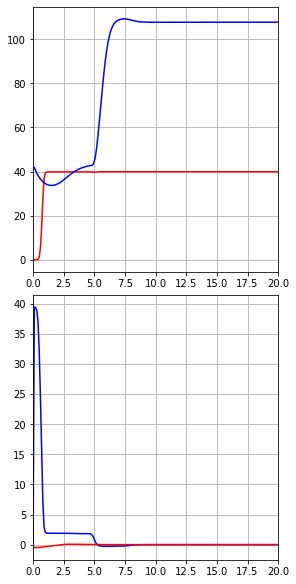

1


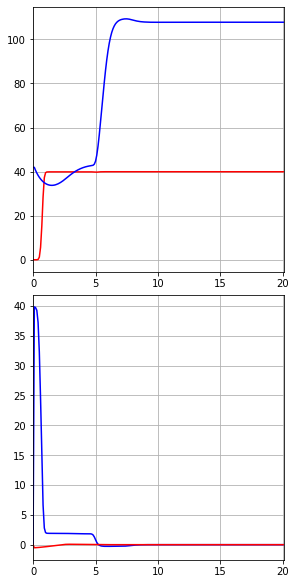

2


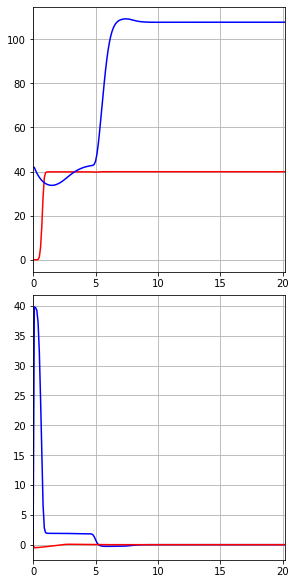

In [34]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    
    if i == 0:
        continue
    
    for j in [0,1,2]:
        
        print(j)
        
        dur = round(d_array[j],1)
        plot_time_array = np.arange(0.,round(dur+aln.params.dt,1),aln.params.dt)

        fig, ax = plt.subplots(2,1, constrained_layout=True, figsize = (4,8) )

        ax[0].plot(plot_time_array, bestState_[i][j][0,0,n_pre-1:-n_post+1], color= 'red')
        ax[0].plot(plot_time_array, bestState_[i][j][0,1,n_pre-1:-n_post+1], color= 'blue')

        ax[1].plot(plot_time_array, bestControl_[i][j][0,0,n_pre-1:-n_post+1], color = 'blue')
        ax[1].plot(plot_time_array, bestControl_[i][j][0,1,n_pre-1:-n_post+1], color = 'red')

        for k in range(2):
            ax[k].set_xlim(0.,dur)
        plt.show()

In [26]:
bestControl_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
bestState_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
cost_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
costnode_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
weights_maxW = np.array( [[None] * len(t_pen)] * len(exc) )
convergence_maxW = np.array( [[None] * len(t_pen)] * len(exc) )

file_maxW = 'up_Wmax.pickle'

In [27]:
if os.path.isfile(file_maxW) :
    print("file found")
    
    with open(file_maxW,'rb') as f:
        load_array = pickle.load(f)

    bestControl_maxW = load_array[0]
    bestState_maxW = load_array[1]
    cost_maxW = load_array[2]
    costnode_maxW = load_array[3]
    weights_maxW = load_array[4]

file found


In [28]:
bestControl_maxW[1][0] = None

In [29]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 0

    while not convergence_maxW[i][j]:

        dur = d_array[0]
        aln.params.duration = dur        
        setinit(initVars[i], aln)

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        control0 = aln.getZeroControl()
        if type(bestControl_maxW[i][j]) == type(None):
            max_it = 10
            control0 = bestControl_[i][0][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] - sum(costnode_[i][j][0][0][:]) ) / sum( costnode_[i][j][cost_index][0][:] )
            cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
            weights_maxW[i][j] = cost.getParams()
        else:
            control0 = bestControl_maxW[i][j][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] - sum(costnode_maxW[i][j][0][0][:]) ) / sum( costnode_maxW[i][j][cost_index][0][:] )
            cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
            weights_maxW[i][j] = cost.getParams()
            max_it = int(100)

        bestControl_maxW[i][j], bestState_maxW[i][j], cost_maxW[i][j], runtime_, grad_, phi_, phi1_, costnode_maxW[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_maxW[i][j][2] == 0.:
            convergence_maxW[i][j] = True

        print('cost splitting : ', costnode_[i][j][0][0][:2], costnode_[i][j][cost_index][0][:2])

        with open(file_maxW,'wb') as f:
            pickle.dump([bestControl_maxW, bestState_maxW, cost_maxW, costnode_maxW, weights_maxW], f)

-------  0 0.4500000000000001 0.4750000000000002
set cost params:  1.0 584.4761518513093 0.0
interpolate adjoint :  True True True
initial cost =  12801.807032522976
RUN  0 , total integrated cost =  12801.807032522976
Gradient descend method:  None
RUN  1 , total integrated cost =  12801.807032522976
Control only changes marginally.
RUN  1 , total integrated cost =  12801.807032522976
Improved over  1  iterations in  0.19567264802753925  seconds by  0.0  percent.
cost splitting :  [416.7567497   0.       ] [2.80883405e+02 1.13389916e-01]
-------  1 0.47500000000000014 0.6000000000000003
set cost params:  1.0 37.97083273965341 0.0
interpolate adjoint :  True True True
initial cost =  16022.670213255866
RUN  0 , total integrated cost =  16022.670213255866
Gradient descend method:  None
RUN  1 , total integrated cost =  13651.342421787576
RUN  2 , total integrated cost =  12713.76857174654
RUN  3 , total integrated cost =  12051.445889823866
RUN  4 , total integrated cost =  11535.994194

KeyboardInterrupt: 

In [ ]:
for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    j = 0
    step = step1

    while j < 2001:
        
        if j >= 1000:
            step = step2
        
        if convergence_maxW[i][j]:
            j += step
            continue

        print('-----', j)

        dur = round(d_array[j],1)
        aln.params.duration = dur
        max_it = int(1000)  

        setinit(initVars[i], aln)
        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[i][0]
        target_[:,1,:] = target[i][1]

        if type(bestControl_maxW[i][j]) == type(None):
            control0 = aln.getZeroControl()
            control0[:,:,:-step] = bestControl_maxW[i][j-step][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] * (1. - t_pen[0]) / (1. - t_pen[j])
                          - sum(costnode_maxW[i][j-step][0][0][:]) ) / sum( costnode_maxW[i][j-step][cost_index][0][:] )
            cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
            weights_maxW[i][j] = cost.getParams()

        else:
            control0 = bestControl_maxW[i][j][:,:,n_pre-1:-n_post+1]
            weight_ = ( cost_uncontrolled[i] * (1. - t_pen[0]) / (1. - t_pen[j])
                           - sum(costnode_maxW[i][j][0][0][:]) ) / sum( costnode_maxW[i][j][cost_index][0][:] )
            cost.setParams(1., weight_ * factor_we, weight_ * factor_ws)
            weights_maxW[i][j] = cost.getParams()

        bestControl_maxW[i][j], bestState_maxW[i][j], cost_maxW[i][j], runtime_, grad_, phi_, phi1_, costnode_maxW[i][j] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])

        if cost_maxW[i][j][2] == 0.:
            convergence_maxW[i][j] = True

        print('cost splitting : ', costnode_maxW[i][j][0][0][:2], costnode_maxW[i][j][cost_index][0][:2])

    with open(file_maxW,'wb') as f:
            pickle.dump([bestControl_maxW, bestState_maxW, cost_maxW, costnode_maxW, weights_maxW], f)          